In [1]:
# Import Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__ # TensorFlow version

'1.1.0'

In [3]:
# Get and load the data
# The size of the data set is about 12 MB
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# Get some insight on the data downloaded
print("Size of: ")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of: 
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
# One-hot-encoding
data.test.labels[0:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
# Convert one-hot-encoded vectors to a single number.
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
# Check for classes of the first 5 images in the test set
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [8]:
# Data Dimensions

# MNIST images are 28 pixels in each dimension
img_size = 28

# Images are stored in one dimensional array of this length
img_size_flat = img_size * img_size

# Tuple with height and width of the images used to reshape
img_shape = (img_size, img_size)

# Number of classes, one class for each 10 digits
num_classes = 10

In [9]:
# Helper Function to plot images
# Function used to plot 9 images in a 3x3 grid, 
# and writing true and predicted classes below each image
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 subplots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plots
        ax.set_xticks([])
        ax.set_yticks([])

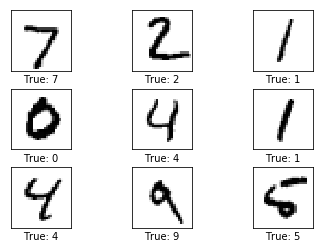

In [10]:
# Plot few images

# Get first 9 images from the test set
images = data.test.images[0:9]

# Get true classes for those 9 images
cls_true = data.test.cls[0:9]

# Plot images and labels using the plot helper function
plot_images(images, cls_true=cls_true)

In [11]:
# Placeholders
x = tf.placeholder(tf.float32, [None, img_size_flat]) # input images
y_true = tf.placeholder(tf.float32, [None, num_classes]) # input image true labels
y_true_cls = tf.placeholder(tf.int64, [None]) # input image true class

In [12]:
# Variables to be optimized
# One hidden layer with 10 neurons.
weights = tf.Variable(tf.zeros([img_size_flat, num_classes])) # 784x10 in this case
biases = tf.Variable(tf.zeros([num_classes]))

In [13]:
# Model
logits = tf.matmul(x, weights) + biases

# Apply softmax (a normalizer) on the logits. Always between 0 and 1. Sums to 1
y_pred = tf.nn.softmax(logits)

# Get the predicted class
y_pred_cls = tf.argmax(y_pred, dimension = 1)

In [14]:
# Cost function to be optimized
# Cross-entropy is a continous function that is always positive.
# If the predicted output of the model exactly matches the desired output then the cross-entropy equals zero.
# So, the goal is to minimize cross-entropy

# Calculate cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, 
                                                        labels=y_true)

In [15]:
# In order for cross-entropy to guide the optimization of the model's 
# variables we need a single scalar value, so simply take the average
# of the cross-entropy for all the image classifications. And that is 
# cost
cost = tf.reduce_mean(cross_entropy)

In [16]:
# Optimization method
# Gradient Descent optimizer with a learning rate of 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
# optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(cost)

In [17]:
# Performance Measure

# prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
# TensorFlow Run

# Create tensorflow session
session = tf.Session()
session.run(tf.global_variables_initializer())

In [19]:
# Stochastic Gradient Descent optimizer function

# Batch size
batch_size = 100

# Optimizer
def optimize(num_iterations):
    for i in xrange(num_iterations):
        # Get a batch of training examples
        # x_batch now holds a batch of images and
        # y_true_batch is the true label
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with proper names
        # for placeholder variables in TF graph
        # Placeholder for y_true_cls is not set
        # because it is not used during training
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to placeholder variables and then runs the optimizer
        session.run(optimizer, feed_dict=feed_dict_train)

In [20]:
# Helper Functions to show the performance

# feed test data into tf
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

# Function to print classification accuracy on the test set
def print_accuracy():
    # TensorFlow to calculate the accuracy
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [21]:
# Function for printing and plotting confusion matrix using scikit-learn
def print_confusion_matrix():
    # Get true classes of the data set
    cls_true = data.test.cls
    
    # Get the predicted classification of the test
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # Get the confusion matrix from sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # Print the confusion matrix as text
    print(cm)
    
    # Plot the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Make some adjustments to the plots
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [22]:
# Function for plotting images that were misclassified in the test-set
def plot_example_errors():
    # Use tensorflow to get a list of boolean values
    # whether each image has been correctly classified,
    # and a list of predicted class for each image
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Negate the boolean array?
    incorrect = (correct == False)
    
    # Get the images from the test set
    # that have been misclassified
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    
    # Get the true classes for those images
    cls_true = data.test.cls[incorrect]
    
    # plot the first 9 images
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])

In [23]:
# Function to plot the model weights.
# 10 images are plotted, 
# one for each digit that the model is trained to recognize
def plot_weights():
    # Get the values for the weights from TensorFlow
    w = session.run(weights)
    
    # Get the highest and lowest value of the weights
    # This is used to correct the color intensity
    # across the images so they can compared with each other
    w_min = np.min(w)
    w_max = np.max(w)
    
    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [24]:
# Performance before optimization
print_accuracy()

Accuracy on test-set: 9.8%


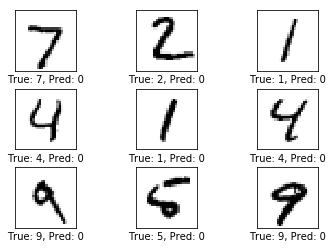

In [25]:
plot_example_errors()

In [26]:
# Performance after 1 optimization iteration
optimize(num_iterations=1)

In [27]:
# accuracy after 1 optimization iteration
print_accuracy()

Accuracy on test-set: 49.5%


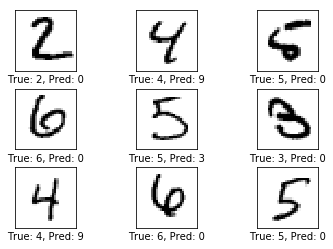

In [28]:
plot_example_errors()

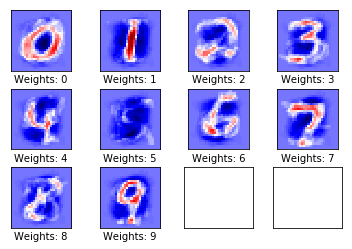

In [29]:
plot_weights()

In [30]:
# Perfomace after 10 optimization iterations
# We have already trained once so
optimize(num_iterations=9)

In [31]:
print_accuracy()

Accuracy on test-set: 72.5%


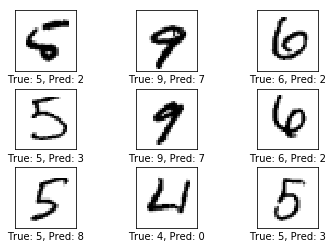

In [32]:
plot_example_errors()

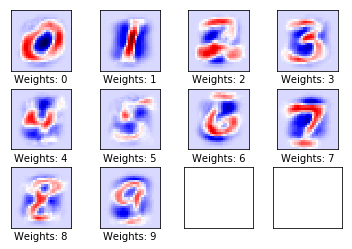

In [33]:
plot_weights()

In [34]:
# performance after 1000 iterations
# Already done with 10 s0
optimize(num_iterations=990)

In [35]:
print_accuracy() # 91.0% with GradientDescentOptimizer and 84.6 % with AdamOptimizer

Accuracy on test-set: 91.0%


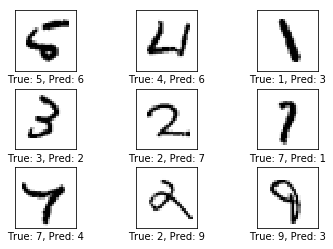

In [36]:
plot_example_errors()

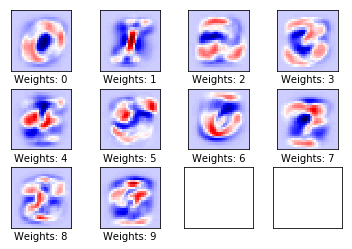

In [37]:
plot_weights()

[[ 958    0    3    2    0    4   10    1    2    0]
 [   0 1107    2    4    0    2    4    1   15    0]
 [  11    8  899   15   14    1   17   17   41    9]
 [   5    2   21  907    1   26    4   14   18   12]
 [   1    4    4    0  897    0   12    1    8   55]
 [  12    4    3   44   11  747   18    8   36    9]
 [  12    3    5    2   11   13  908    1    3    0]
 [   3   19   24    5   11    0    0  916    3   47]
 [  10    9    8   26    8   24   14   13  845   17]
 [  11    7    4   10   32   13    1   14    6  911]]


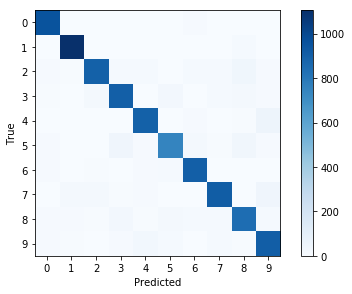

In [38]:
print_confusion_matrix()

In [39]:
session.close()